In [6]:
from dotenv import load_dotenv

load_dotenv()

True

In [ ]:
from typing_extensions import List, Dict, TypedDict, Annotated
from langgraph.graph import MessagesState

class State(MessagesState):
    product_name: str
    product_description: str
    category: str
    data: List[Dict]

class TitleState(State):
    title: str

class BPState(State):
    bp: List[str]

class DescriptionState(State):
    description: str

class TitleOutput(TypedDict):
    title: Annotated[str, ..., '규칙에 맞는 제목, 200자를 넘어가면 안됨']

class BPOutput(TypedDict):
    bp: Annotated[List[str], ..., '규칙에 맞는 BP, 각각 50자를 넘어가면 안됨']
    
class DescriptionOutput(TypedDict):    
    description: Annotated[str, ..., '규칙에 맞는 설명, 2000자를 넘어가면 안됨']

In [8]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o', temperature=0)

In [27]:
from langchain_core.prompts import PromptTemplate
from langchain_core.prompts.few_shot import FewShotPromptTemplate

title_examples = [
    {
        "keyword": "chicken, chicken shredder, tools, chicken shredder tool twist, meat shredder, shredder, pork, tool, hand tools, meat shredder tool twist, chicken shredder tool twist large, shredder kitchen, chicken shredder tool, food shredder, chicken breast, kitchen, food, meat, shredded chicken, cooked chicken, kitchen gadgets, meal prep, kitchen tools, amazon kitchen, cooking gifts, cooking gadgets",
        "title": "Chicken Shredder, 10'' Large Chicken Shredder Tool Twist with Transparent Lid, Ergonomic Handle and Anti-Slip Base, Dishwasher Safe, Ideal for Meal Prep"
    }
]

title_example_prompt = PromptTemplate(
    input_variables=["keyword", "title"],
    template="""
[키워드]
{keyword}
[출력]
최종 타이틀: {title}
"""
)

title_prefix = """
예시는 참고용으로 사용하고, 다음 정보를 확인해서 아마존 상품의 타이틀을 작성해 주세요.
목표는 검색 노출을 극대화 하는 것으로, 반드시 아래 규칙을 지켜주세요

[규칙]
1. Title의 길이는 200자를 넘어가면 안됩니다.
2. 첫 80자에는 핵심 내용(브랜드명, 제품명, Key attribute 등)이 들어가야 합니다
3. 후반부에는 제품과 관련된 중요한 키워드를 제시해야 합니다.
4. 더 제시할 키워드가 없다면, 생성해서 채우지 말고 그 시점에서 답변을 반환하세요
"""


title_snuffix = """
[데이터]
상품명: {product_name}
카테고리: {category}
상품 설명: {product_description}
---
[키워드]
{keyword}
---
[출력]
최종 타이틀:  
"""

title_prompt = FewShotPromptTemplate(
    examples=title_examples,
    example_prompt=title_example_prompt,
    prefix=title_prefix,
    suffix=title_snuffix,
    input_variables=["product_name", "category", "product_description", "keyword"],
)

In [ ]:
def generate_title(state: TitleState):
    prompt = title_prompt.invoke(
        {
            'product_name': state['product_name'], 
            'category': state['category'],
            'product_description': state['product_description'], 
            'keyword': state['data'],
        }
    )
    structured_llm = llm.with_structured_output(TitleOutput)
    res = structured_llm.invoke(prompt)
    return {'title': res['title']}

In [26]:
from langchain_core.prompts import PromptTemplate
from langchain_core.prompts.few_shot import FewShotPromptTemplate

bp_examples = [
    {
        "keyword": "chicken, chicken shredder, tools, chicken shredder tool twist, meat shredder, shredder, pork, tool, hand tools, meat shredder tool twist, chicken shredder tool twist large, shredder kitchen, chicken shredder tool, food shredder, chicken breast, kitchen, food, meat, shredded chicken, cooked chicken, kitchen gadgets, meal prep, kitchen tools, amazon kitchen, cooking gifts, cooking gadgets",
        "bp": [
            'EASY SHREDDING: Effortlessly shred cooked chicken, pork, or beef into even pieces, perfect for tacos, salads, sandwiches, and more. Save time and elevate meal prep with this essential kitchen tool.',
            'STABLE ANTI-SLIP BASE: Equipped with a non-slip base for stability, ensuring safe and efficient shredding without the tool slipping during use.'
            'LARGE CAPACITY WITH TRANSPARENT LID: The 10-inch size accommodates family-sized portions. The transparent lid lets you monitor the shredding process, ensuring perfect results every time.',
            'ERGONOMIC HANDLE DESIGN: Designed with a comfortable, easy-grip handle to reduce hand strain and improve control, making shredding tasks quick and effortless.',
            'DISHWASHER SAFE: Made for convenience, the shredder is dishwasher-safe and easy to clean, ensuring a hassle-free experience in busy kitchens.',
        ]
    }
]

bp_example_prompt = PromptTemplate(
    input_variables=["keyword", "bp"],
    template="""
[키워드]
{keyword}
[출력]
최종 Bullet Point: {bp}
"""
)

bp_prefix = """
예시는 참고용으로 사용하고, 다음 정보를 확인해서 아마존 상품의 Bullet Point를 작성해 주세요.
목표는 고객에게 정확한 정보를 전하고, 고객이 사용하고 싶게 만드는 것으로, 반드시 아래 규칙을 지켜주세요

[규칙]
1. 각 BP의 길이는 50자를 넘어가면 안됩니다.
2. 첫 3개의 BP는 상품의 효능에 관련된 설명으로, 고객 입장에서 상품의 가치를 판단할 수 있는 키워드를 사용합니다.
3. 나머지 2개의 BP는 상품의 기능에 관련된 설명으로, 상품이 할 수 있는 기능에 관한 키워드를 사용합니다.
4. 더 제시할 키워드가 없다면, 생성해서 채우지 말고 그 시점에서 답변을 반환하세요
5. 키워드를 나열하는 식이 아닌, 문장형으로 작성하세요.
"""

bp_snuffix = """
[데이터]
상품명: {product_name}
카테고리: {category}
상품 설명: {product_description}
---
[키워드]
{keyword}
---
[출력]
최종 BP:  
"""

bp_prompt = FewShotPromptTemplate(
    examples=bp_examples,
    example_prompt=bp_example_prompt,
    prefix=bp_prefix,
    suffix=bp_snuffix,
    input_variables=["product_name", "category", "product_description", "keyword"],
)

In [ ]:
def generate_bp(state: BPState):
    prompt = bp_prompt.invoke(
        {
            'product_name': state['product_name'], 
            'category': state['category'],
            'product_description': state['product_description'], 
            'keyword': state['data'],
        }
    )
    structured_llm = llm.with_structured_output(BPOutput)
    res = structured_llm.invoke(prompt)
    return {'bp': res['bp']}

In [71]:
from langchain_core.prompts import PromptTemplate
from langchain_core.prompts.few_shot import FewShotPromptTemplate

description_examples = [
    {
        "keyword": "chicken, chicken shredder, tools, chicken shredder tool twist, meat shredder, shredder, pork, tool, hand tools, meat shredder tool twist, chicken shredder tool twist large, shredder kitchen, chicken shredder tool, food shredder, chicken breast, kitchen, food, meat, shredded chicken, cooked chicken, kitchen gadgets, meal prep, kitchen tools, amazon kitchen, cooking gifts, cooking gadgets",
        "description": '''
[Why You'll Love It]
 
  The 10'' Chicken Shredder Tool Twist is your ultimate kitchen companion for quick, safe, and efficient meal preparation. Whether you're making shredded chicken tacos, salads, or pulled pork sandwiches, this tool saves time and effort, delivering professional results in seconds.
 
  [Key Features]
 
  • Effortless Shredding: Quickly and evenly shred cooked chicken, pork, or beef for various dishes.
 
  • Non-Slip Stability: The anti-slip base ensures safety and ease during use.
 
  • Large Capacity: Perfect for family-sized meals with a 10-inch bowl and a transparent lid to monitor the process.
 
  • Ergonomic Design: Comfortable handle reduces hand strain and ensures optimal control.
 
  • Easy Maintenance: Dishwasher-safe design makes cleaning a breeze.
 
  [Perfect for These People]
 
  Crafted with durability in mind, this versatile shredder is ideal for home cooks, meal prep enthusiasts, BBQ lovers, and even pet owners needing a quick way to prepare shredded meat. Add this must-have gadget to your kitchen and transform your cooking experience.
        
        '''
    }
]

description_example_prompt = PromptTemplate(
    input_variables=["keyword", "description"],
    template="""
[키워드]
{keyword}
[출력]
최종 Description: {description}
"""
)

description_prefix = """
예시를 참고하고, 다음 정보를 확인해서 아마존 상품의 Description를 작성해 주세요.
목표는 고객에게 정확한 정보를 깔끔하게 전달하는 것으로, 반드시 아래 규칙을 지켜주세요

[규칙]
1. Description의 최대 길이는 2000자입니다.
2. 첫 200자 안에 최대한 의미있는 내용을 중요한 키워드를 포함해 한 문장으로 작성하세요.
3. 나머지 내용은 고객이 읽기 편하게 키워드를 활용해서 작성하세요.
4. 더 제시할 키워드가 없다면, 생성해서 채우지 말고 그 시점에서 답변을 반환하세요
5. answer must be written in english
"""

description_snuffix = """
[데이터]
상품명: {product_name}
카테고리: {category}
상품 설명: {product_description}
---
[키워드]
{keyword}
---
[출력]
최종 Description:  
"""

description_prompt = FewShotPromptTemplate(
    examples=description_examples,
    example_prompt=description_example_prompt,
    prefix=description_prefix,
    suffix=description_snuffix,
    input_variables=["product_name", "category", "product_description", "keyword"],
)

In [ ]:
def generate_description(state: DescriptionState):
    prompt = description_prompt.invoke(
        {
            'product_name': state['product_name'], 
            'category': state['category'],
            'product_description': state['product_description'], 
            'keyword': state['data'],
        }
    )
    structured_llm = llm.with_structured_output(DescriptionOutput)
    res = structured_llm.invoke(prompt)
    return {'description': res['description']}

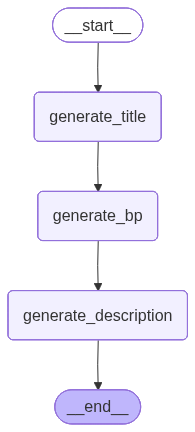

In [63]:
from langgraph.graph import START, StateGraph

# 단순히 1열로 노드들이 진행되는 경우 만드는게 매우 간단함
builder = StateGraph(State).add_sequence(
    [generate_title, generate_bp, generate_description]
)

builder.add_edge(START, 'generate_title')

graph = builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [64]:
import pandas as pd

keywords = pd.read_csv('./processed_chicken_shredder_keywords_0915.csv')['Keywords'].to_frame(name='keywords').to_dict(orient='records')[:50]
keywords

[{'keywords': 'chicken shredder'},
 {'keywords': 'chicken shredder tool twist'},
 {'keywords': 'wedding registry items'},
 {'keywords': 'mini chopper'},
 {'keywords': 'chicken shredder tool'},
 {'keywords': 'chicken accessories'},
 {'keywords': 'chicken breast shredder'},
 {'keywords': 'processor'},
 {'keywords': 'chicken shredder amazon'},
 {'keywords': 'mini blender food processor'},
 {'keywords': 'chicken grinder'},
 {'keywords': 'shredded chicken tool'},
 {'keywords': 'choper'},
 {'keywords': 'cluckmaster chicken shredder'},
 {'keywords': 'chicken shredder large chicken breast shredder tool'},
 {'keywords': 'chicken shreader'},
 {'keywords': 'shredder chicken'},
 {'keywords': 'garlic blender'},
 {'keywords': 'top selling items on amazon'},
 {'keywords': 'amazon chicken shredder'},
 {'keywords': 'small chopper mini'},
 {'keywords': 'shredder for chicken'},
 {'keywords': 'black and decker chopper'},
 {'keywords': 'food blender small'},
 {'keywords': 'chicken shreder'},
 {'keywords': 

In [72]:
final_state = graph.invoke({
    'product_name': 'Chicken Shredder',
    'category': 'Kitchen Gadgets',
    'product_description': 'it is a tool to rip chicken breasts. easy to use, and easy to dishwash',
    'data': keywords,
})

from pprint import pprint
pprint(final_state)

{'bp': ['EASY SHREDDING: Effortlessly shred cooked chicken, pork, or beef into '
        'even pieces, perfect for tacos, salads, sandwiches, and more.',
        'STABLE ANTI-SLIP BASE: Equipped with a non-slip base for stability, '
        'ensuring safe and efficient shredding without the tool slipping '
        'during use.',
        'LARGE CAPACITY WITH TRANSPARENT LID: The 10-inch size accommodates '
        'family-sized portions. The transparent lid lets you monitor the '
        'shredding process, ensuring perfect results every time.',
        'ERGONOMIC HANDLE DESIGN: Designed with a comfortable, easy-grip '
        'handle to reduce hand strain and improve control, making shredding '
        'tasks quick and effortless.',
        'DISHWASHER SAFE: Made for convenience, the shredder is '
        'dishwasher-safe and easy to clean, ensuring a hassle-free experience '
        'in busy kitchens.'],
 'category': 'Kitchen Gadgets',
 'data': [{'keywords': 'chicken shredder'},
     